In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from skimage.feature import hog
from scipy.ndimage.measurements import label
import os
import random
import time
import glob
from sklearn.externals import joblib
import pickle
from moviepy.editor import VideoFileClip


class VehicleTracker():
    def __init__(self, spatial_size=(8, 8), color_param=([0,1,2], 8), 
                 hog_param=([0], 5, 8, 2), use_spatial=True, use_color_hist=True, use_hog=True):
        self.spatial_size = spatial_size
        self.color_channels = color_param[0]
        self.color_bins = color_param[1]
        self.hog_channel = hog_param[0]
        self.hog_orient = hog_param[1]
        self.hog_pix = hog_param[2]
        self.hog_cells = hog_param[3]
        self.hog_transform = False
        self.use_spatial = use_spatial
        self.use_color_hist = use_color_hist
        self.use_hog = use_hog
        self.clf_size = (64, 64)
        self.hog_blocks = (self.clf_size[0] // self.hog_pix)-1
        self.heat_map_threshold = 8
        self.ystart = 360
        self.ystop = 670
        self.clf = None
        self.X_scaler = None
        self.heat_history = []
        
    def __str__(self):
        print_string = ("Vehicle Detection Parameters\n" +
                        "Spatial:\t%r\n" % self.use_spatial +
                        "  Spatial Size:\t%s\n" % (self.spatial_size,) +
                        "Color:\t\t%r\n" % self.use_color_hist +
                        "  Channels:\t%s\n" % self.color_channels +
                        "  Bins:\t\t%i\n" % self.color_bins +
                        "HOG:\t\t\t%r\n" % self.use_hog +
                        "  Channel:\t\t%i\n" % self.hog_channel +
                        "  Orientations:\t\t%i\n" % self.hog_orient +
                        "  Pixels per Cell:\t%i\n" % self.hog_pix +
                        "  Cells per Block:\t%i\n" % self.hog_cells +
                        "  Sqrt Transform:\t%r\n" % self.hog_transform +
                        "Window\n" +
                        "  Start:\t%i\n" % self.ystart +
                        "  Stop:\t\t%i\n" % self.ystop +
                        "Classifier:\t" + str(vt.clf)[:9] + "\n" +
                        "  Scaler:\t %s\n" + str(vt.X_scaler)[:14] + 
                        "  Size:\t\t%s\n" % (self.clf_size,) +
                        "  Heat Threshold: %i\n" % self.heat_map_threshold
                       )
        return print_string
        
    def convert_to_LUV(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    
    def convert_to_YCrCb(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    def get_spatial_feature(self, img):
        return cv2.resize(img, self.spatial_size).ravel()
    
    def get_color_feature(self, img):
        """ Color histogram feature of image.  Range is set for standard 0 to 256 image.
        Channels to extract histogram from is stored in color_channels
        Number of bins in the histogram is stored in color_bins
        img -- image to obtain histogram feature
        return -- single, concatenated array of histogram bin values
        """
        color_features = []
        for channel in self.color_channels:
            channel_hist, _ = np.histogram(img[:,:,channel], bins=self.color_bins, range=(0,256), density=False)
            color_features.append(channel_hist)
        if len(self.color_channels) > 1:
            color_features = np.concatenate(color_features)
        return np.ravel(color_features)
    
    def generate_hog(self, img, channel=0, vis=False):
        if vis == True:
            # Use skimage.hog() to get both features and a visualization
            hog_feature, hog_image = hog(img[:,:,channel], orientations=self.hog_orient, 
                                         pixels_per_cell=(self.hog_pix, self.hog_pix),
                                         cells_per_block=(self.hog_cells, self.hog_cells), 
                                         transform_sqrt=self.hog_transform, 
                                         visualise=vis, feature_vector=False)
            feature_size = len(np.ravel(hog_feature))
            return feature_size, hog_image
        else:
            # Extract just HOG data without flattening for use with sub sample window
            feature = hog(img[:,:,channel], orientations=self.hog_orient, 
                          pixels_per_cell=(self.hog_pix, self.hog_pix),
                          cells_per_block=(self.hog_cells, self.hog_cells), 
                          transform_sqrt=self.hog_transform, 
                          visualise=vis, feature_vector=False)
            return feature
        
    def extract_features(self, image):
        # convert to LUV color space
#         cvt_image = self.convert_to_LUV(image)
        cvt_image = self.convert_to_YCrCb(image)
        
        # Extract features
        feature = []
        if self.use_spatial:
            feature.extend(self.get_spatial_feature(cvt_image))
        if self.use_color_hist:
            feature.extend(self.get_color_feature(cvt_image))
        if self.use_hog:
            for channel in self.hog_channel:
                hog_feature = self.generate_hog(cvt_image, channel)
                hog_feature = np.ravel(hog_feature)
                feature.extend(hog_feature)
        return feature
        
    def region_of_interest(self, image, height=None, width=None):
        img_h, img_w, _ = np.shape(image)
        if not width:
            width = img_w
        if not height:
            y_stop = self.ystop
        else:
            y_stop = self.ystart + height
        
        center = img_w/2
        x_start = np.int(center - width/2)
        x_stop = np.int(x_start + width)
        return image[self.ystart:y_stop, x_start:x_stop, :], x_start
    
    def split_data(self, X, y, test_ratio):
        # Train test split of data
        rand_state = 121 # set initial random state for consistancy
        X_shuffled, y_shuffled = shuffle(X, y, random_state=rand_state)
        # Split up data into randomized training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_ratio, random_state=rand_state)
        return X_train, X_test, y_train, y_test
    
    def normalize_image(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        image[:,:,0] = cv2.equalizeHist(image[:,:,0])
        image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
        return image
    
    def augment_data(self, image_files):
            features = []
            for image in image_files:
                img = cv2.imread(image, 1)
                features.append(self.extract_features(img))
                # Augment data with horz. flipped image
                img = cv2.flip(img, 1)
#                 features.append(self.extract_features(img))
                # Augment data with normalized and flipped variants
                img = self.normalize_image(img)
                features.append(self.extract_features(img))
#                 img = cv2.flip(img, 1)
#                 features.append(self.extract_features(img))
            return features
    
    def train_classifier(self, car_folder, non_car_folder, deep):
        # Gather training images
        if deep:
            car_files = glob.glob(car_folder + '**/*.png')
            non_car_files = glob.glob(non_car_folder + '**/*.png')
        else:
            car_files = glob.glob(car_folder + '*.png')
            non_car_files = glob.glob(non_car_folder + '*.png')
        print(len(car_files), "car images")
        print(len(non_car_files), "non-car images")
        
        # Generate feature vector
        print("Constructing car features...", end=' ')
#         car_features = []
#         for car in car_files:
#             car = cv2.imread(car, 1)
#             car_features.append(self.extract_features(car))
#             # Augment data with horz. flipped image
#             flip_car = cv2.flip(car, 1)
#             car_features.append(self.extract_features(flip_car))
#             # Augment data with normalized and flipped variants
#             car = self.normalize_image(car)
#             car_features.append(self.extract_features(car))
#             flip_car = cv2.flip(car, 1)
#             car_features.append(self.extract_features(flip_car))

        car_features = self.augment_data(car_files)
        print("Complete!")
        
        print("Constructing non-car features...", end=' ')
#         non_car_features = []
#         for non_car in non_car_files:
#             non_car = cv2.imread(non_car, 1)
#             non_car_features.append(self.extract_features(non_car))
#             # Augment data with horz. flipped image
#             flip_non_car = cv2.flip(non_car, 1)
#             non_car_features.append(self.extract_features(flip_non_car))
#             # Augment data with normalized and flipped variants
#             non_car = self.normalize_image(non_car)
#             non_car_features.append(self.extract_features(non_car))
#             flip_non_car = cv2.flip(non_car, 1)
#             non_car_features.append(self.extract_features(flip_non_car))
        
        non_car_features = self.augment_data(non_car_files)
        print("Complete!")
        X_raw = np.vstack((car_features, non_car_features)).astype(np.float64)
        
        # Construct label vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
        
        # Normalize with scalar
        self.X_scaler = StandardScaler().fit(X_raw)
        X = self.X_scaler.transform(X_raw)
        print("Normalization Complete.")
        
        # Split Data into Train and Test
        X_train, X_test, y_train, y_test = self.split_data(X, y, 0.05)
        print("Data Split Complete")
        
        
        
        # Create Classifier
        self.clf = LinearSVC()
        
        # Train Classifier
        print('Feature vector length:', len(X_train[0]))
        # Check the training time for the SVC
        print("Starting Classifier Fit")
        t=time.time()
        self.clf.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test accuracy of classifier = ', round(self.clf.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('Classifier predictions:\t', self.clf.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels:\t', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'seconds to predict', n_predict,'labels with classifier.')
        
        # save classifier
        clf_file = {"classifier": self.clf,
                   "scaler": self.X_scaler}
        joblib.dump(clf_file, 'vehicle_classifier.pkl') 
        
    def load_classifier(self):
        clf_file = joblib.load('vehicle_classifier.pkl')
        self.clf = clf_file["classifier"]
        self.X_scaler = clf_file["scaler"]
        if self.clf == None or self.X_scaler == None:
            print("Load Failed")
        else:
            print("Classifier Loaded")
    
    def test_window(self, image, hog_maps, min_corner):
        # Sub sample image and resize for classifer
        image_window = np.asarray(min_corner)*(self.hog_pix)
        img_window = image[image_window[1]:image_window[1]+self.clf_size[1], image_window[0]:image_window[0]+self.clf_size[0]]

        # Extract features
        feature = []
        # Extract spatial feature
        if self.use_spatial:
            spatial_feature = self.get_spatial_feature(img_window)
            feature.extend(spatial_feature)
        # Extract color histogram feature
        if self.use_color_hist:
            color_feature = self.get_color_feature(img_window) 
            feature.extend(color_feature)
        # Extract hog sub sample feature
        if self.use_hog:
            # Sub sample hog map and resize for classifier
            for hog_map in hog_maps:
                hog_window = hog_map[min_corner[1]:min_corner[1]+self.hog_blocks, min_corner[0]:min_corner[0]+self.hog_blocks]
                # Flatten hog sub sample
                hog_feature = np.ravel(hog_window)
                feature.extend(hog_feature)
        
        # Apply standard scalar to feature
        feature = np.asarray(feature).astype(np.float64)
        feature = feature.reshape(1, -1)
        scaled_feature = self.X_scaler.transform(feature)        
        return self.clf.predict(scaled_feature)
    
    def search_image(self, image, step_size=1, show_all=False):
#         window_size = [288, 216, 160, 128, 96, 64]
#         y_starts = [0, 0, 0, 0, 0, 0] 
#         y_stops = [vt.ystop, vt.ystop, vt.ystop, vt.ystop, vt.ystop, vt.ystop]
        window_sizes = [160]#216]
        y_starts = [300]#320]
        y_stops = [670]#670]
        
        # List to store windows with cars
        windows_with_cars = []
    
        # normalize image, after testing this seems to hurt prodcution performance.
#         image = self.normalize_image(image)
        # convert to YCrCb colorspace
        cvt_image = self.convert_to_YCrCb(image)
        
        for window_size, y_start, y_stop in zip(window_sizes, y_starts, y_stops):
            # Crop to region of interest
            roi_image = cvt_image[y_start:y_stop,:,:]
            img_shape = np.shape(roi_image)
            
            # calculate scaling and resize image
            scale = window_size/self.clf_size[0]
            if scale != 1.0:
                roi_image = cv2.resize(roi_image, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
            hog_maps = []
            for channel in self.hog_channel:
                hog_maps.append(self.generate_hog(roi_image, channel))
            search_height, search_width, _ = np.shape(roi_image)
            
            # rescale to blocks
            search_height = search_height//self.hog_pix
            search_width = search_width//self.hog_pix
            
            
            top = 0
            while top+self.hog_blocks < search_height:
                left = 0
                while left+self.hog_blocks < search_width:
                    min_corner = (left, top)
                    prediction = self.test_window(roi_image, hog_maps, min_corner)
                    if prediction == 1 or show_all:
                        # Adjust the postion of the window from the coordinates of the cropped
                        # image to the coordinates of the master image
                        x_pos = np.int(left*self.hog_pix*scale)
                        y_pos = np.int(top*self.hog_pix*scale+y_start)
                        adj_size = np.int(self.clf_size[0]*scale)
                        adj_window = [(x_pos, y_pos), (x_pos+adj_size, y_pos+adj_size)]
                        windows_with_cars.append(adj_window)
                    left += step_size
                top += step_size
        return windows_with_cars
    
    def generate_heatmap(self, image, windows_with_cars):
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        for window in windows_with_cars:
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
        heatmap = cv2.GaussianBlur(heatmap, (31, 31), 0)
        return heatmap
    
    def threshold_heatmap(self, heatmap):
        heatmap[heatmap <= self.heat_map_threshold] = 0
        return heatmap
    
    def bbox_cars(self, image, verbose=False):
        t=time.time()
        # Find windows with cars in them
        windows_with_cars = self.search_image(image)
        # Generate heatmap for this frame
        heatmap = self.generate_heatmap(image, windows_with_cars)
      
        # Construct a history of the heatmaps
        if self.heat_history == None:
            self.heat_history = []
            for _ in range(5):
                self.heat_history.append(heatmap)
        
        # Threshold the heatmap       
        heatmap = self.threshold_heatmap(heatmap)
        
        self.heat_history.append(heatmap)
        # remove oldest heatmap once history fills up
        while len(self.heat_history) > 2:
            self.heat_history.pop(0)        
            # decay old heatmaps and sum over time
            history_length = len(vt.heat_history)
#             heatmap = np.sum(np.multiply(vt.heat_history, 1/history_length*np.arange(history_length).reshape(-1, 1, 1)), axis=0)
            heatmap = np.mean(vt.heat_history, axis=0)
#             heatmap = self.threshold_heatmap(heatmap)
            
        label_cars = label(heatmap)
        if verbose:
            print(len(label_cars[1]), "found!")
            print(label_cars)
        for car_number in range(1, label_cars[1]+1):
            # Find pixels with each car_number label value
            nonzero = (label_cars[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(image, bbox[0], bbox[1], (0,255,0), 6)
        # Return the image
        t2=time.time()
        frames_per_second = 1.0/(t2-t)
        cv2.putText(image, "Heatmap Max%7.0f" % np.max(heatmap), (25, 50), 0, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(image, "Frame Rate%7.3f" % frames_per_second, (25, 75), 0, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        return image
    
    def process_video(self, video_file):
        self.heat_history = None
        clip1 = VideoFileClip(video_file)
        project_clip = clip1.fl_image(self.bbox_cars)
        project_clip.write_videofile('output_videos/processed_'+video_file, audio=False)

Classifier Loaded


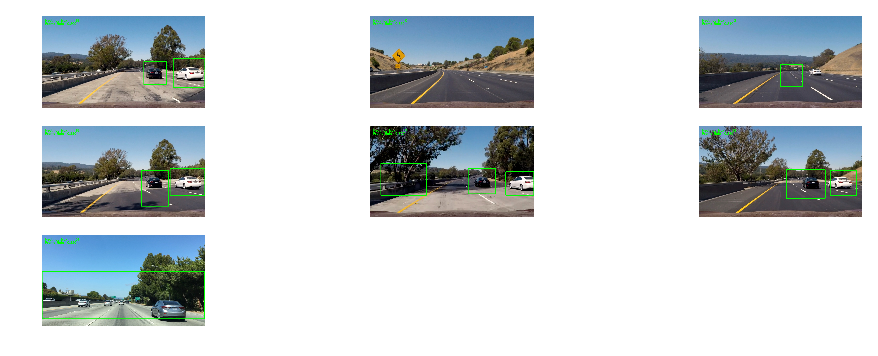

In [142]:
vt = VehicleTracker()
vt.load_classifier()
vt.heat_map_threshold = 1
images = glob.glob('test_images/*.jpg')
figure = plt.figure(figsize=(12,4))
i = 1
for image in images:
    image = cv2.imread(image, 1)
    vt.heat_history = []
    boxed_image = vt.bbox_cars(image)
    plt.subplot(len(images)//3+1,3,i)
    plt.imshow(rgb(boxed_image))
    plt.axis('off')
    i += 1
#     plt.show()
plt.show()

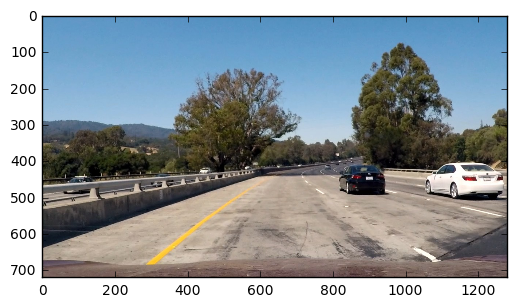

Classifier Loaded
23


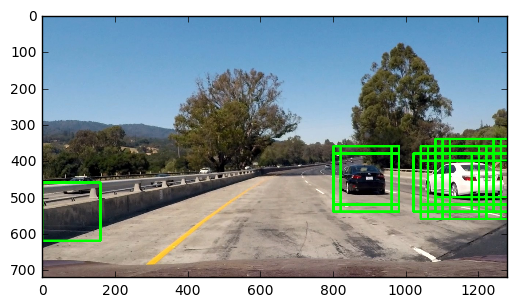

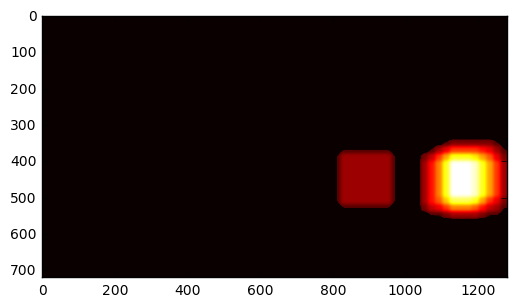

In [146]:
image = cv2.imread('test_images/test1.jpg', 1)
# image = np.ones_like(image)
plt.imshow(rgb(image))
plt.show()
vt = VehicleTracker()
vt.load_classifier()
vt.heat_map_threshold = 2
# vt.train_classifier('vehicles/', 'non-vehicles/', deep=True)
# vt.train_classifier('vehicles/KITTI_extracted/', 'non-vehicles/Extras/', deep=False)
car_windows = vt.search_image(image, show_all=False)
print(len(car_windows))
for bbox in car_windows:
    cv2.rectangle(image, bbox[0], bbox[1], (0,255,0), 6)
plt.imshow(rgb(image))
plt.show()
heatmap = vt.generate_heatmap(image, car_windows)
heatmap = vt.threshold_heatmap(heatmap)
plt.imshow(heatmap, cmap='hot')
plt.show()

Classifier Loaded


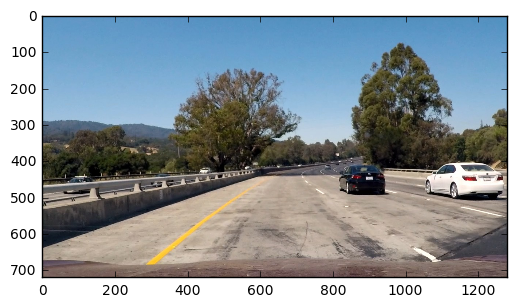

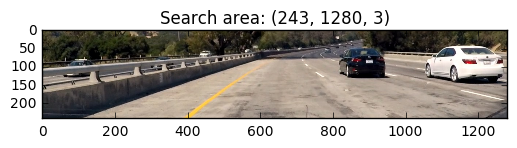

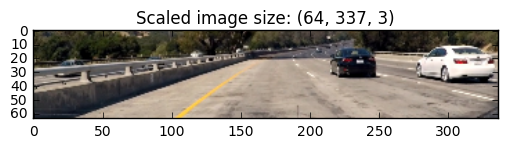

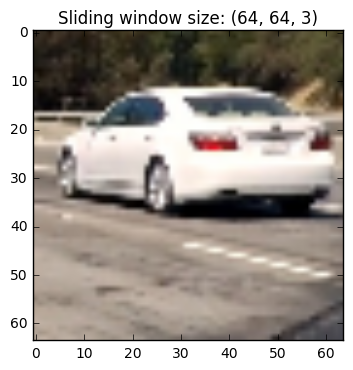

Feature length (1, 1196)
prediction from classifier:  [ 1.]


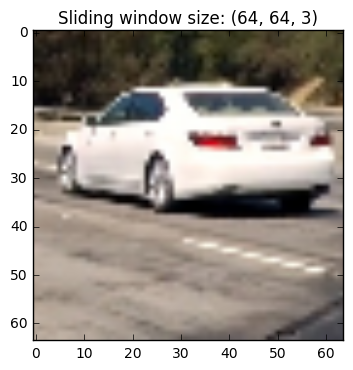

Feature length (1, 1196)
prediction from classifier:  [ 1.]


In [72]:
vt = VehicleTracker()
# vt.train_classifier('vehicles/', 'non-vehicles/')
vt.load_classifier()

image = cv2.imread('test_images/test1.jpg', 1)
# image = vt.normalize_image(image)
plt.imshow(rgb(image))
plt.show()

windows = 35
step = 1
width = int((64-8*step+step*8*windows))
height = int(1280/width*64)
roi_image = image[vt.ystart:vt.ystart+height,:,:]
plt.imshow(rgb(roi_image))
plt.title("Search area: %s" % (np.shape(roi_image),))
plt.show()
scale = height/vt.clf_size[0]
scaled_image = cv2.resize(roi_image, (np.int(1280/scale), vt.clf_size[0]))
plt.imshow(rgb(scaled_image))
plt.title("Scaled image size: %s" % (np.shape(scaled_image),))
plt.show()
hog_map = vt.generate_hog(scaled_image)
step = step*8
position = (windows-1)*step
sliding_window = scaled_image[:,position:position+vt.clf_size[0],:]
plt.imshow(rgb(sliding_window))
plt.title("Sliding window size: %s" % (np.shape(sliding_window),))
plt.show()
feature = vt.extract_features(sliding_window)
feature = np.asarray(feature).astype(np.float64)
feature = feature.reshape(1,-1)
feature = vt.X_scaler.transform(feature)
print("Feature length", np.shape(feature))
prediction = vt.clf.predict(feature)
print("prediction from classifier: ", prediction)
ypos = 95
scaled_image = cv2.resize(image, (np.int(1280/scale), np.int(720/scale)))
sliding_window = scaled_image[ypos:ypos+vt.clf_size[0],position:position+vt.clf_size[0],:]
plt.imshow(rgb(sliding_window))
plt.title("Sliding window size: %s" % (np.shape(sliding_window),))
plt.show()
feature = vt.extract_features(sliding_window)
feature = np.asarray(feature).astype(np.float64)
feature = feature.reshape(1,-1)
feature = vt.X_scaler.transform(feature)
print("Feature length", np.shape(feature))
prediction = vt.clf.predict(feature)
print("prediction from classifier: ", prediction)

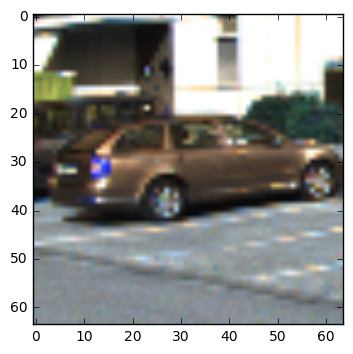

[ 1.]
[ 1.]


In [162]:
image = get_random_car_image()
# image = get_random_non_car_image()
plt.imshow(image)
plt.show()
feature = vt.extract_features(image)
feature = np.asarray(feature).astype(np.float64)
feature = feature.reshape(1,-1)
feature = vt.X_scaler.transform(feature)
prediction = vt.clf.predict(feature)
print(prediction)
luv_image = vt.convert_to_LUV(image)
hog_map = vt.generate_hog(luv_image)
window = (0, 0)
prediction = vt.test_window(luv_image, hog_map, window)
print(prediction)

In [2]:
def get_random_car_image(folder='vehicles/KITTI_extracted/'):
    img_file = random.sample(os.listdir(folder), 1)
    return cv2.imread(folder + img_file[0], 1)

def get_random_non_car_image(folder='non-vehicles/GTI/'):
    img_file = random.sample(os.listdir(folder), 1)
    return cv2.imread(folder + img_file[0], 1)

def compare_images(images, titles, axis='off'):
    """ Create figure from a list of images
    images -- [[image1, image2], [image3, image4]] n X m array of images arranged as displayed
    titles -- list of titles for each image
    """
    rows = len(images)
    cols = len(images[0])
    index = 1
    img_shape = np.shape(images[0][0])
    figure = plt.figure(figsize=(4*cols,3*rows))
    for row in images:
        for image in row:
            plt.subplot(rows, cols, index)
            plt.title(titles[index-1])
            plt.axis(axis)
            plt.imshow(image, cmap='gray')
            index += 1
    plt.show()
    
def read_files(folder, file_type='jpg', deep=False):
    if deep:
        images = glob.glob(folder+'**/*.'+file_type)
    else:
        images = glob.glob(folder+'*'+file_type)
    return images

def rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [24]:
# image = mpimg.imread('test_images/test1.jpg')
image = get_random_car_image()
print("Color feature size:   ", len(vt.get_color_feature(image)))
print("Spatial feature size: ", len(vt.get_spatial_feature(image)))
print("HOG feature size:     ", len(np.ravel(vt.generate_hog(image))))
print("Feature size:         ", len(vt.extract_features(image)))

Color feature size:    24
Spatial feature size:  192
HOG feature size:      1764
Feature size:          5508


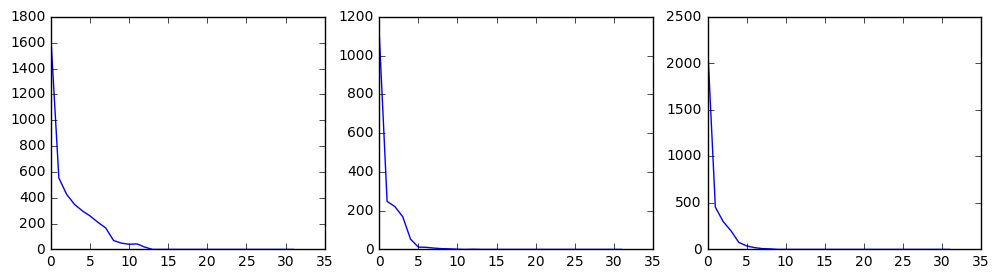

In [198]:
image = get_random_car_image()
# print(np.shape(image))
luv_image = vt.convert_to_LUV(image)
vt.color_channels = [0]
color_hist = vt.get_color_feature(luv_image)
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(color_hist)
vt.color_channels = [1]
color_hist = vt.get_color_feature(luv_image)
plt.subplot(132)
plt.plot(color_hist)
vt.color_channels = [2]
color_hist = vt.get_color_feature(luv_image)
plt.subplot(133)
plt.plot(color_hist)
plt.show()

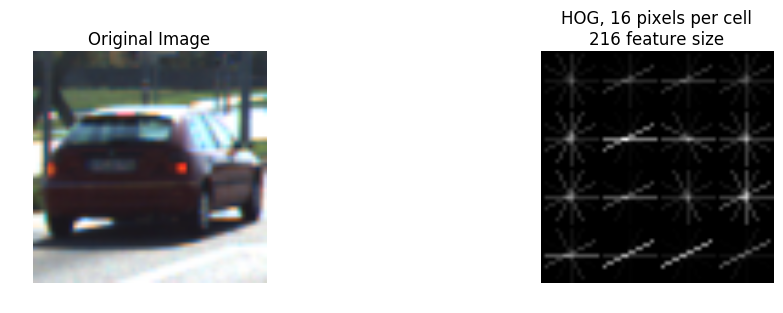

(3, 3, 2, 2, 6)


In [65]:
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(rgb(image))
plt.axis('off')

plt.subplot(122)
plt.title("HOG, %i pixels per cell\n%i feature size" % (vt.hog_pix, hog_size))
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.show()
hog_feature = vt.generate_hog(cvt_image)
print(np.shape(hog_feature))

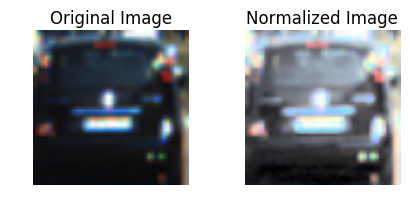

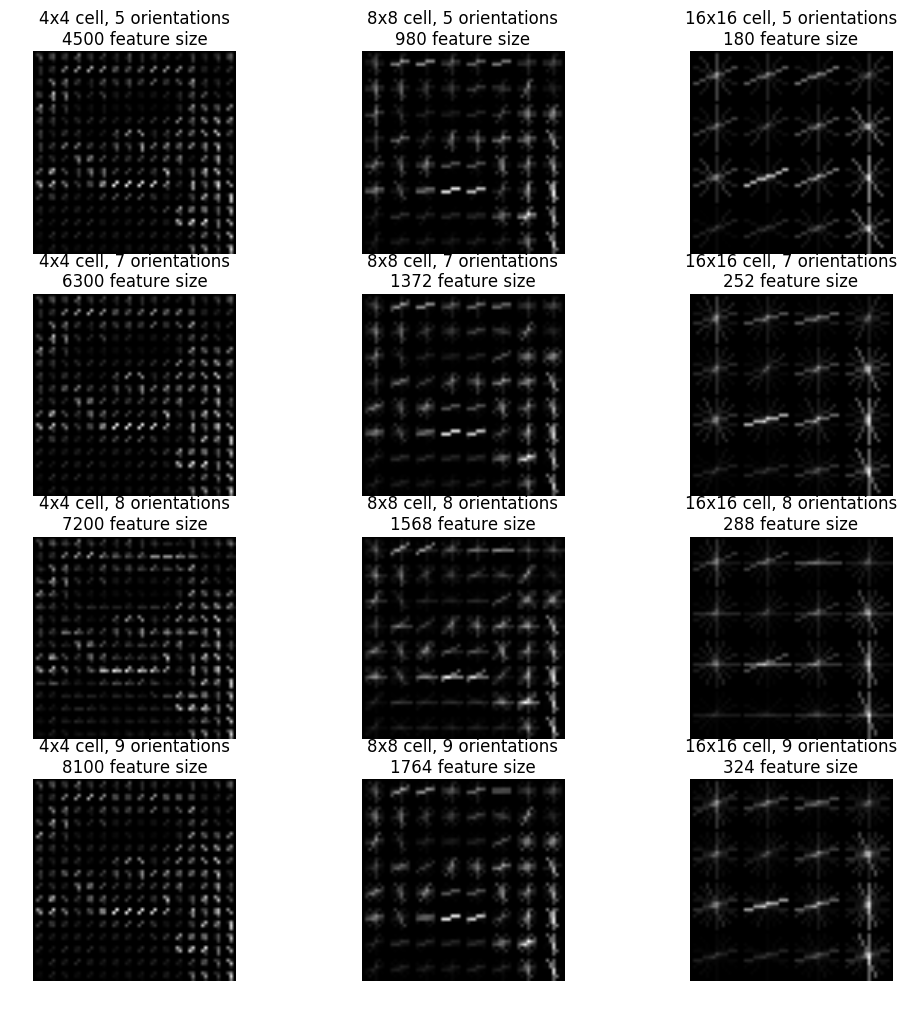

In [73]:
hog_compare_images = []
hog_compare_titles = []

# hog cell sizes to examine
trial_pix_per_cell = [4, 8, 16]
trial_orients = [5, 7, 8, 9]

image = get_random_car_image()
norm_image = vt.normalize_image(image)
cvt_image = vt.convert_to_YCrCb(norm_image)

plt.figure(figsize=(5,2))
plt.subplot(121)
plt.imshow(rgb(image))
plt.title("Original Image")
plt.axis('off')
plt.subplot(122)
plt.imshow(rgb(norm_image))
plt.title("Normalized Image")
plt.axis('off')
plt.show()

vt.hog_channels = [0]
vt.hog_cells = 2

for orients in trial_orients:
    vt.hog_orient = orients
    row = []
    for pix in trial_pix_per_cell:
        vt.hog_pix = pix
        hog_size, hog_img = vt.generate_hog(cvt_image, vis=True)
        row.append(hog_img)
        hog_compare_titles.append("%ix%i cell, %i orientations\n%i feature size" % 
                                  (vt.hog_pix, vt.hog_pix, vt.hog_orient, hog_size))
    hog_compare_images.append(row)
compare_images(hog_compare_images, hog_compare_titles)

In [392]:
vt = VehicleTracker()
print(vt)
vt.train_classifier('vehicles/', 'non-vehicles/')

Vehicle Detection Parameters
Spatial:	True
  Spatial Size:	(8, 8)
Color:		True
  Channels:	[0, 1, 2]
  Bins:		32
HOG:			True
  Channel:		0
  Orientations:		5
  Pixels per Cell:	8
  Cells per Block:	2
  Sqrt Transform:	False
Window
  Start:	380
  Stop:		670
Classifier:	None
  Size:		(64, 64)
  Heat Threshold: 2
Search Windows:	225
8792 car images
8968 non-car images
Constructing car features... Complete!
Constructing non-car features... Complete!
Normalization Complete.
Data Split Complete
Feature vector length: 1268
Starting Classifier Fit
6.79 Seconds to train SVC...
Test accuracy of classifier =  0.9724
Classifier predictions:	 [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  0.]
For these 10 labels:	 [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  0.]
0.003 seconds to predict 10 labels with classifier.


In [355]:
vt.load_classifier()
print(vt)

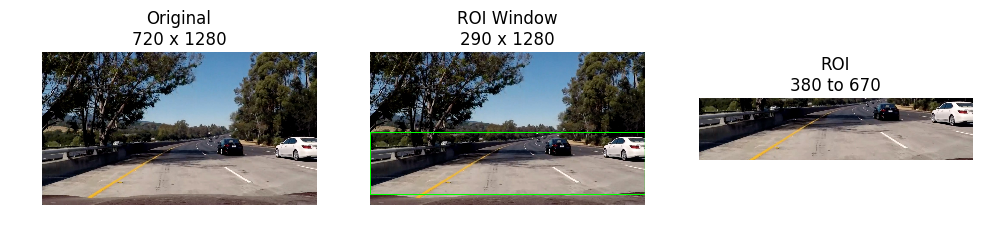

In [373]:
# All
# test_images = read_files('test_images/', 'jpg')

# One
test_images = ['test_images/test5.jpg']

vt.ystart = 380 
vt.ystop = 670
roi_h = vt.ystop-vt.ystart

roi_compare = []
roi_titles = []
for image in test_images:
    row = []
    image = mpimg.imread(image)
    row.append(image)
    draw_roi = np.copy(image)
    img_h, img_w, _ = np.shape(draw_roi)
    cv2.rectangle(draw_roi,(0, vt.ystart),(img_w, vt.ystop),(0,255,0),3)
    row.append(draw_roi)
    roi_image = vt.region_of_interest(image)
    row.append(roi_image)
    roi_compare.append(row)
    roi_titles.append(["Original\n%i x %i" % (img_h, img_w), "ROI Window\n%i x %i" % (roi_h, img_w), "ROI\n%i to %i" % (vt.ystart, vt.ystop)])

roi_titles = np.ravel(roi_titles)
compare_images(roi_compare, roi_titles)

In [301]:
windows = vt.window_gen(0, 1280, 290, 64, 2, windows = [], verbose = True)
print(len(windows), "total search windows.")

14 (290, 290) windows
20 (218, 218) windows
28 (164, 164) windows
39 (123, 123) windows
52 (93, 93) windows
72 (70, 70) windows
225 total search windows.


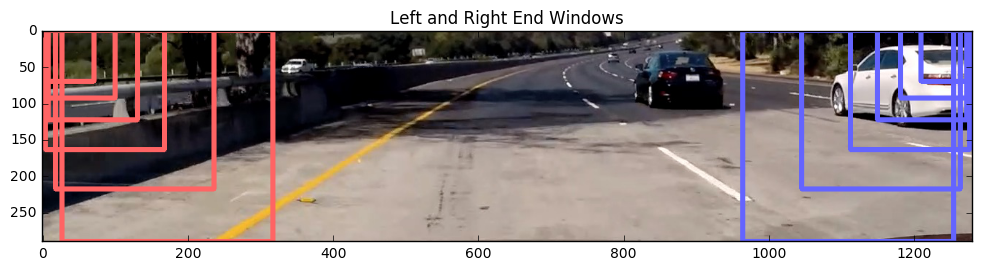

In [438]:
image = mpimg.imread('test_images/test5.jpg')
window_test = vt.region_of_interest(image)
edge_windows = [0]
edge_windows.append(edge_windows[-1]+14)
edge_windows.append(edge_windows[-1]+20)
edge_windows.append(edge_windows[-1]+28)
edge_windows.append(edge_windows[-1]+39)
edge_windows.append(edge_windows[-1]+52)

for i in edge_windows:
    min_corner, max_corner = vt.search_windows[i]
    cv2.rectangle(window_test, min_corner, max_corner, (255, 100, 100), 5)
    min_corner, max_corner = windows[i-1]
    cv2.rectangle(window_test, min_corner, max_corner, (100, 100, 255), 5)
    
figure = plt.figure(figsize=(12,3))
plt.imshow(window_test)
plt.title("Left and Right End Windows")
plt.show()
    

In [357]:
print(vt)

Vehicle Detection Parameters
Spatial:	True
  Spatial Size:	(8, 8)
Color:		True
  Channels:	[0, 1, 2]
  Bins:		32
HOG:			True
  Channel:		0
  Orientations:		5
  Pixels per Cell:	8
  Cells per Block:	2
  Sqrt Transform:	False
Window
  Start:	380
  Stop:		670
Classifier: LinearSVC
  Size:		(64, 64)
  Heat Threshold: 2
Search Windows:	225


In [475]:
vt = VehicleTracker()
vt.load_classifier()
roi_image = vt.region_of_interest(image)
print(np.shape(image))
print(np.shape(roi_image))
luv_image = vt.convert_to_LUV(roi_image)
print(np.shape(luv_image))
hog_map = vt.generate_hog(luv_image)
print(np.shape(hog_map))
vt.extract_window_features(luv_image, hog_map, vt.search_windows[0])
vt.X_scaler

Classifier Loaded
(64, 64, 3)
(2,)


TypeError: src is not a numerical tuple

(64, 64, 3)


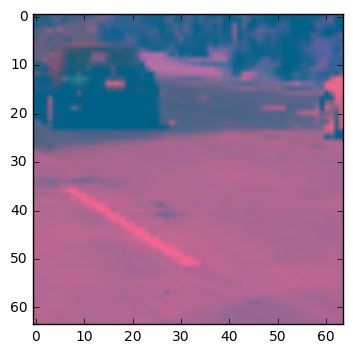

In [433]:
window = vt.search_windows[11]
img_window = cv2.resize(luv_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], vt.clf_size)

print(np.shape(img_window))
plt.imshow(img_window)
plt.show()

In [211]:
# Checking image data on import
jpeg = cv2.imread('test_images/test1.jpg')
png = cv2.imread('vehicles/GTI_Far/image0037.png')
print("cv2 image import")
print(np.max(jpeg[:,:,0]), np.max(jpeg[:,:,1]), np.max(jpeg[:,:,2]))
print(np.max(png[:,:,0]), np.max(png[:,:,1]), np.max(png[:,:,2]))

jpeg = mpimg.imread('test_images/test1.jpg')
png = mpimg.imread('vehicles/GTI_Far/image0037.png')
print("\nmpimg image import")
print(np.max(jpeg[:,:,0]), np.max(jpeg[:,:,1]), np.max(jpeg[:,:,2]))
print(np.max(png[:,:,0]), np.max(png[:,:,1]), np.max(png[:,:,2]))

255 255 255
196 198 184
255 255 255
0.721569 0.776471 0.768627


In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [58]:
vt = VehicleTracker()
vt.load_classifier()
vt.heat_map_threshold = 6
project_video = 'test_video.mp4'
vt.process_video(project_video)

Classifier Loaded
[MoviePy] >>>> Building video output_videos/processed_test_video.mp4
[MoviePy] Writing video output_videos/processed_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:22<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/processed_test_video.mp4 



In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/processed_'+project_video))

In [39]:
project_video = 'project_video.mp4'
vt.process_video(project_video)

[MoviePy] >>>> Building video output_videos/processed_project_video.mp4
[MoviePy] Writing video output_videos/processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [11:57<00:00,  1.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/processed_project_video.mp4 



In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/processed_'+project_video))

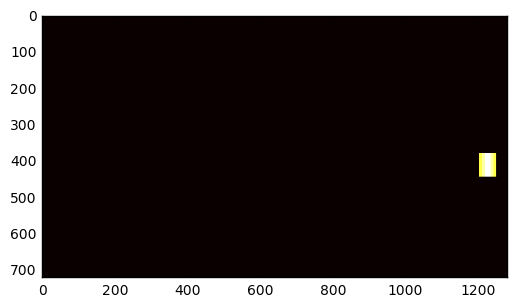

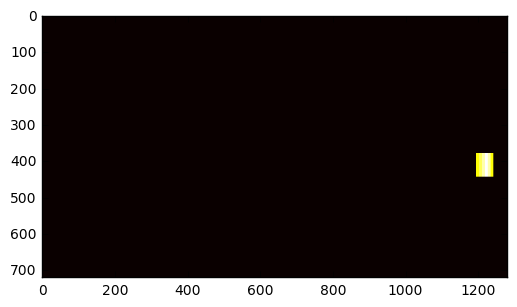

In [42]:
maximum_heat = np.max(vt.heat_history)
vt.heat_map_threshold = 8
for heatmap in vt.heat_history:
#     plt.imshow(heatmap/maximum_heat, cmap='hot')
    hm = vt.threshold_heatmap(heatmap)
    plt.imshow(hm, cmap='hot')
    plt.show()

In [74]:
# norm_heat = np.max(vt.heat_history)
decay = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]).reshape((-1,1,1))

hm = np.sum(np.multiply(vt.heat_history, decay), axis=0)
plt.imshow(np.sum(vt.heat_history, axis=0), cmap='hot')
plt.show()
plt.imshow(hm, cmap='hot')
plt.show()

hm = vt.threshold_heatmap(hm)
plt.imshow(hm, cmap='hot')
plt.show()

ValueError: operands could not be broadcast together with shapes (5,720,1280) (10,1,1) 

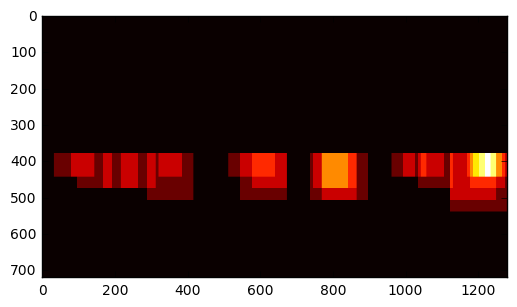

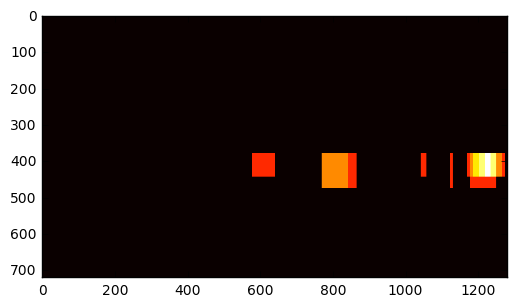

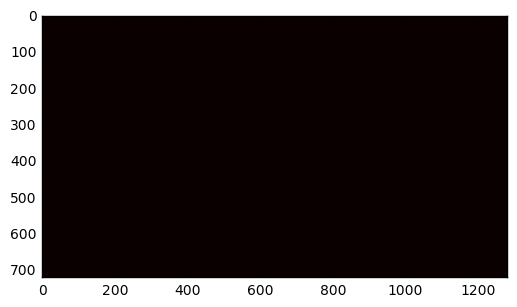

In [75]:
og_map = vt.heat_history[-1]
plt.imshow(og_map, cmap='hot')
plt.show()
decay_map = og_map*0.9
decay_map = vt.threshold_heatmap(decay_map)
plt.imshow(decay_map, cmap='hot')
plt.show()
decay_map = decay_map*0.3
decay_map = vt.threshold_heatmap(decay_map)
plt.imshow(decay_map, cmap='hot')
plt.show()
# kernel = np.ones((16,16),np.uint8)
# erode_hm = cv2.erode(og_map, kernel, iterations=1)
# plt.imshow(erode_hm, cmap='hot')
# plt.show()
# erode_hm = cv2.erode(erode_hm, kernel, iterations=1)
# plt.imshow(erode_hm, cmap='hot')
# plt.show()

In [113]:
history = vt.heat_history
history = [hm*0.9 for hm in history]

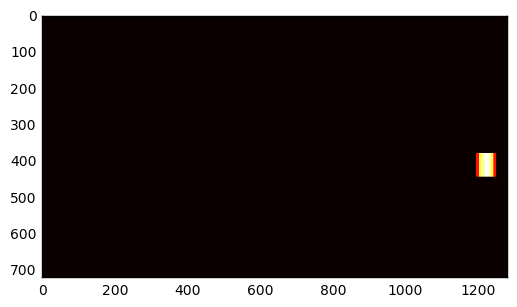

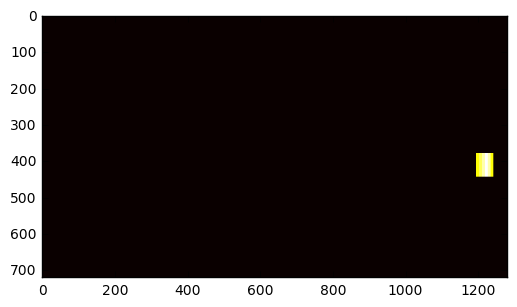

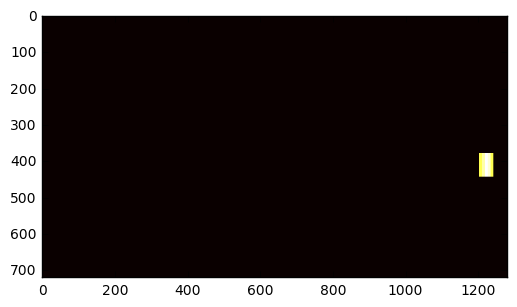

In [44]:
heatmap = np.sum(vt.heat_history, axis=0)
heatmap = vt.threshold_heatmap(heatmap)
plt.imshow(heatmap, cmap='hot')
plt.show()
heatmap = np.sum(np.multiply(vt.heat_history, 1/len(vt.heat_history)*np.arange(len(vt.heat_history)).reshape(-1, 1, 1)), axis=0)
# heatmap = vt.threshold_heatmap(heatmap)
plt.imshow(heatmap, cmap='hot')
plt.show()
heatmap = np.mean(vt.heat_history, axis=0)
heatmap = vt.threshold_heatmap(heatmap)
plt.imshow(heatmap, cmap='hot')
plt.show()

In [145]:
1/len(vt.heat_history)*np.arange(len(vt.heat_history)).reshape(-1, 1, 1)

array([[[ 0. ]],

       [[ 0.2]],

       [[ 0.4]],

       [[ 0.6]],

       [[ 0.8]]])